In [1]:
from bs4 import BeautifulSoup
import requests
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import numpy
import json

sns.set_context('talk')
sns.set_style('whitegrid')
%matplotlib notebook

In [2]:
class RunMeta(object):
    
    def __init__(self, js):
        self.js = js
        
    def dump(self):
        return json.dumps(self.js, 
                          sort_keys=True, 
                          indent=4, 
                          separators=(',', ': '))

    def run_number(self):
        return self.js['record']['cycle']['run']
        

class RunCat(object):
    logger = logging.getLogger("runcat")
    
    def __init__(self):
        self._latest_ = None
        self._reference_ = None
    
    @property
    def latest(self):
        if self._latest_ is None:
            self.get_latest()
        return self._latest_
    
    @property
    def reference(self):
        if self._reference_ is None:
            self.get_reference(self.latest)
        return self._reference_        
        
    
    def get_latest(self):
        r = requests.get("http://ubdaq-prod-near2.fnal.gov/RunCat/data/latest.txt")
        self._latest_ = int(r.text)
    
    def get_run_info(self, run_n):
        url = 'http://ubdaq-prod-near2.fnal.gov/RunCat/data/run_{}.json'.format(str(run_n).zfill(8))
        return RunMeta(requests.get(url).json())
    
    def get_serve_hists(self, run_n, hists='HLIST'):
        payload = {'run': '{}'.format(run_n),
                   'hists': hists,
                   'options': ':maxListDepth2:'
                   }
        url = "http://ubdaq-prod-near2.fnal.gov/Lizard/{}/server/serve_hists.cgi".format(run_n)
        return requests.post(url, data=payload)
    
    def get_reference(self, run_n):
        payload={'filename':'reference.root','hists':'','options':':maxListDepth2:'}
        url = "http://ubdaq-prod-near2.fnal.gov/Lizard/{}/server/serve_hists.cgi".format(run_n)
        self._reference_= int(json.loads(requests.post(url, data=payload).text)['record']['cycle']['run'])

In [3]:
rc = RunCat()
print rc.reference
print rc.get_run_info(rc.latest).dump()

10849
{
    "header": {
        "num_events": 0,
        "run": 12422,
        "start": "2017-08-16T12:10:36.436550+00:00",
        "stop": "2017-08-16T14:50:08.184836+00:00"
    },
    "run_data": {
        "SN": {
            "seb01": {
                "data_size": 72052000364,
                "end": "2017-08-16T14:50:50.077827+00:00",
                "live_time": 9612.910783999998,
                "seb": "seb01",
                "start": "2017-08-16T12:10:37.080046+00:00"
            },
            "seb02": {
                "data_size": 100260000500,
                "end": "2017-08-16T14:50:50.210723+00:00",
                "live_time": 9613.097942999997,
                "seb": "seb02",
                "start": "2017-08-16T12:10:36.829795+00:00"
            },
            "seb03": {
                "data_size": 131708000660,
                "end": "2017-08-16T14:50:50.614679+00:00",
                "live_time": 9613.702373999997,
                "seb": "seb03",
                "sta

In [4]:
print json.dumps(json.loads(rc.get_serve_hists(rc.latest-1).text), sort_keys=True, indent=4, separators=(',', ': '))

{
    "error": "Couldn't find file for this event specification.",
    "serve_event_log": "testing\nThis is ubdaq-prod-near1.fnal.gov Parameters recieved: run,options,hists <br/>Filename undefined <br/>Using run: -00012421-<br/>serve_hists.cgi looking in pathglob: /datalocal/om/run_00012421*.om.root<br/>//run_00012421*.om.root<br/><br/>\n"
}


In [5]:
print rc.get_serve_hists(rc.latest-1, hists='/tpc/plane2/h_54_pulseheight_vs_walltime:/errors/h_data_errors').text

{"error":"Couldn't find file for this event specification.","serve_event_log":"testing\nThis is ubdaq-prod-near1.fnal.gov Parameters recieved: run,options,hists <br/>Filename undefined <br/>Using run: -00012421-<br/>serve_hists.cgi looking in pathglob: /datalocal/om/run_00012421*.om.root<br/>//run_00012421*.om.root<br/><br/>\n"}


<IPython.core.display.Javascript object>


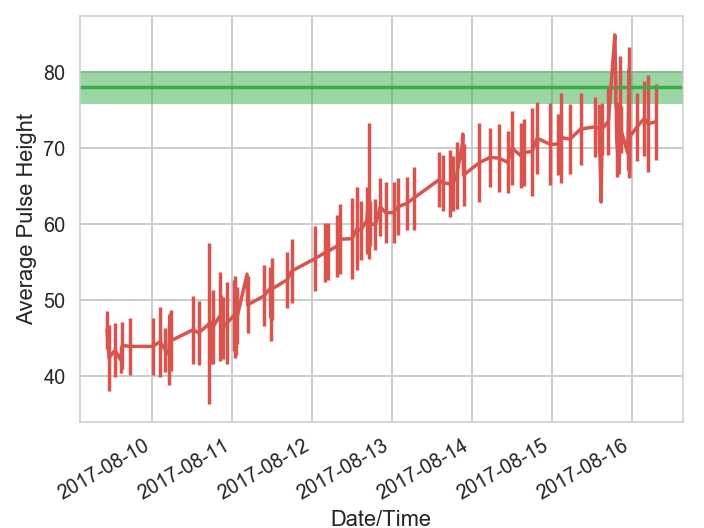

In [6]:
ref_dat = json.loads(rc.get_serve_hists(rc.reference, hists='/tpc/plane2/h_54_pulseheight_vs_walltime:/errors/h_data_errors').text)
ref_y = ref_dat['record']['shipment']["/tpc/plane2/h_54_pulseheight_vs_walltime"]['data']
valid_y = [int(i) for i in ref_y if i>0]

ref_y_ave = sum(valid_y)/len(valid_y)
ref_y_std = np.std(valid_y)/2.0

x=[]
y=[]
y_err=[]
for i in range(150):
    
    try:
        latest_dat = json.loads(rc.get_serve_hists(rc.latest-i, 
                                                   hists='/tpc/plane2/h_54_pulseheight_vs_walltime:/errors/h_data_errors').text)
        latest_y = latest_dat['record']['shipment']["/tpc/plane2/h_54_pulseheight_vs_walltime"]['data']
        valid_y = [float(i) for i in latest_y if i>0.0]
        latest_y_ave = sum(valid_y)/len(valid_y)
        latest_y_err = np.std(valid_y)
        latest_x = latest_dat['record']['cycle']['firstEventTime']
        latest_x = datetime.datetime.fromtimestamp(latest_x/1000)
        x.append(latest_x)
        y.append(latest_y_ave)
        y_err.append(latest_y_err)
    except:
        continue

ax = plt.figure()
plt.errorbar(x,y,yerr=y_err, color=sns.xkcd_rgb["pale red"])
plt.axhspan(ref_y_ave-ref_y_std, ref_y_ave+ref_y_std, alpha=0.5, color=sns.xkcd_rgb["medium green"])
plt.axhline(y=ref_y_ave, hold=None, color=sns.xkcd_rgb["medium green"])
plt.xlabel('Date/Time')
plt.ylabel('Average Pulse Height')
plt.tight_layout()
ax.autofmt_xdate()
plt.show()
plt.savefig("purity.png")

<IPython.core.display.Javascript object>


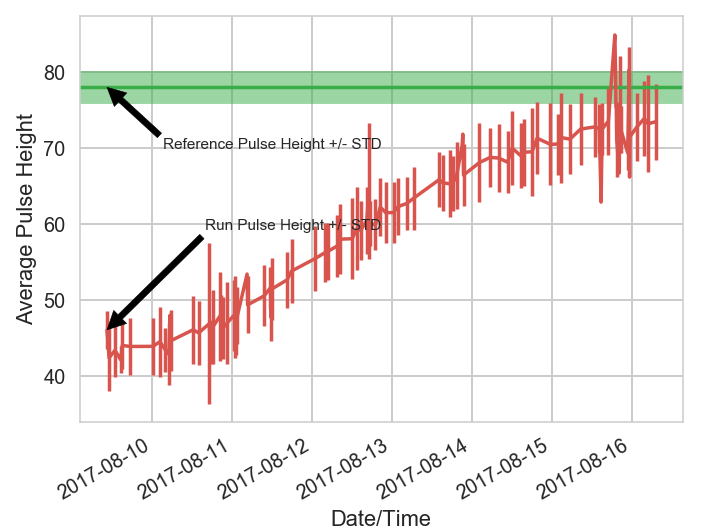

2.51442339315


In [7]:
ax = plt.figure()
print(latest_y_err)
plt.errorbar(x,y,yerr=y_err, color=sns.xkcd_rgb["pale red"])
plt.axhspan(ref_y_ave-ref_y_std, ref_y_ave+ref_y_std, alpha=0.5, color=sns.xkcd_rgb["medium green"])
plt.axhline(y=ref_y_ave, hold=None, color=sns.xkcd_rgb["medium green"])
plt.xlabel('Date/Time')
plt.ylabel('Average Pulse Height')

plt.annotate('Reference Pulse Height +/- STD', xy=(latest_x,ref_y_ave ),  xycoords='data',
            xytext=(0.5, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.001),
            horizontalalignment='right', verticalalignment='top',
            )

plt.annotate('Run Pulse Height +/- STD', xy=(latest_x,latest_y_ave  ),  xycoords='data',
            xytext=(0.5, 0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.001),
            horizontalalignment='right', verticalalignment='top',
            )



plt.tight_layout()
ax.autofmt_xdate()
plt.show()
plt.savefig("purity_annotated.png")